In [122]:
import numpy as np

# from QAOA.binary.binary_exp_optimizer import optimal_params

# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
N = 2  # 表示机器的二进制 (0, 1)
n = 2  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数
# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3], [2, 3, 1]])

b = np.array([[0, 0], [1, 0], [0, 1]])
# 非法数组(用于表示机器数)(1, 1)
bw = np.array([[1, 1]])
# 常数
K1 = 100
P = 200
# print(len(bw))j
# 量子比特数量
num_qubits = n * N + l

In [123]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    实现多体 Z 相互作用项 e^{-i \gamma Z_1 Z_2 \dots Z_k}.
    """
    if len(qubits) == 1:
        qc.rz(2 * gamma, qubits[0])
        return

    # 链式 CNOT 到最后一个量子比特
    for q in qubits[:-1]:
        qc.cx(q, qubits[-1])

    # 应用 RZ 门
    qc.rz(2 * gamma, qubits[-1])

    # 恢复链式 CNOT
    for q in reversed(qubits[:-1]):
        qc.cx(q, qubits[-1])


In [110]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(2 * gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(2 * gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

\begin{equation}
H=-\sum_{h=0}^{l-1} 2^{h-1} Z_h
\end{equation}

In [111]:
def get_cost_circuit1(gamma, qc):
    for h in range(l):
        angle = gamma * (-2 ** (h - 1))
        # coef = - 2**h
        append__z_term(qc, N * n + h, angle)
    return qc

\begin{align}K_{1} \sum_{j\in W} \sum_{i=0}^{n}\prod_{k=0}^{N}\left(\frac{1}2+\left(\frac{1}2-b_{j k}\right)Z_{ik}\right)\end{align}

In [112]:
import itertools


def get_cost_circuit2(gamma, qc):
    if len(bw) == 0:
        return qc
    # 包含空集（r=0）
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(1, N + 1))))
    for j in range(len(bw)):
        for i in range(n):
            for qubit_indices in all_combinations:
                constant = 1.0 / (2 ** N)
                qubits_index = []
                for k in range(N):
                    if k in qubit_indices:
                        constant *= (1 - 2 * bw[j, k])
                        qubits_index.append(i * N + k)
                # 空集项单独处理（仅常数项）
                # if len(qubit_indices) == 0:
                #     qc.rz(2 * K1 * constant * gamma, 0)  # 假设量子比特0为辅助位
                # else:
                append_multi_rzz_term(qc, qubits_index, K1 * constant * gamma)
    return qc


\begin{align}\sum_{j=0}^{m-1}\sum_{i=0}^{n-1} \sum_{i^{\prime}=0}^{n-1}\left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j}\left(\prod_{k^{\prime}=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i^{\prime} k^{\prime}}\right)\right) p_{i^{\prime} j}\end{align}
\begin{align}-2 \sum_{j=0}^{m-1} \sum_{i=0}^{n-1} \sum_{h=0}^{l-1} \left(\prod_{k=0}^{N-1}\frac{1}{2}\left(1+\left(1-2b_{j k}\right) Z_{i k}\right)\right) p_{i j} \cdot 2^{h-1}\left(1-Z_h\right)\end{align}
\begin{align}\sum_{j=0}^{m-1}\sum_{h=0}^{l-1} \sum_{h^{\prime}=0}^{l-1} 2^{h-1} 2^{h^{\prime}-1}\left(1-Z_h-Z_{h^{\prime}}+Z_h Z_{h^{\prime}}\right)\end{align}

In [113]:
# import itertools
from collections import Counter


def get_cost_circuit3(gamma, qc):
    # 预计算所有组合（含空集）
    all_combinations = list(itertools.chain(*(itertools.combinations(range(N), r) for r in range(0, N + 1))))

    for j in range(m):  # 遍历所有机器
        # 处理所有i和i'的组合（包括i=i'）
        for i1 in range(n):
            for i2 in range(n):
                for combo1 in all_combinations:
                    for combo2 in all_combinations:
                        # 计算系数
                        constant = (1 / (2 ** (2 * N))) * p[i1, j] * p[i2, j]
                        qubits = []
                        # 处理combo1（i1的比特）
                        for k in combo1:
                            constant *= (1 - 2 * b[j, k])
                            qubits.append(i1 * N + k)
                        # 处理combo2（i2的比特）
                        for k in combo2:
                            constant *= (1 - 2 * b[j, k])
                            qubits.append(i2 * N + k)
                        # 合并相同量子比特（奇数次保留）
                        count = Counter(qubits)
                        qubits_final = [q for q, cnt in count.items() if cnt % 2 == 1]
                        if len(qubits_final) > 0:
                            # 添加哈密顿量项
                            append_multi_rzz_term(qc, qubits_final, P * constant * gamma)
    for j in range(m):
        for i in range(n):
            for combo in all_combinations:  # 包含空集
                # 计算prod项系数
                constant_prod = (1 / (2 ** N)) * p[i, j]
                qubits_prod = []
                for k in combo:
                    constant_prod *= (1 - 2 * b[j, k])
                    qubits_prod.append(i * N + k)
                # 处理与Z_h的交叉项
                for h in range(l):
                    # 项1: 1 * 2^{h-1}
                    constant_term1 = constant_prod * 2 ** (h - 1)
                    if len(qubits_prod) > 0:
                        append_multi_rzz_term(qc, qubits_prod, -2 * P * constant_term1 * gamma)
                    # 项2: -Z_h * 2^{h-1}
                    constant_term2 = constant_prod * 2 ** (h - 1)
                    qubits_zh = qubits_prod + [n * N + h]
                    if len(qubits_zh) > 0:
                        append_multi_rzz_term(qc, qubits_zh, 2 * P * constant_term2 * gamma)
    for h1 in range(l):
        for h2 in range(l):
            coef = 2 ** (h1 - 1) * 2 ** (h2 - 1) * P * gamma
            # 1 项（全局相位，通常可忽略）
            # -Z_{h1} 项
            append__z_term(qc, n * N + h1, -coef)
            # -Z_{h2} 项
            append__z_term(qc, n * N + h2, -coef)
            # Z_{h1}Z_{h2} 项
            if h1 != h2:
                append__zz_term(qc, n * N + h1, n * N + h2, coef)
            else:
                # 当 h1=h2 时，Z_h^2=I，无贡献
                pass

In [114]:
def get_mixer_circuit(beta, qc):
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
    return qc

In [115]:
def invert_counts(s):
    return s[::-1]

In [116]:
from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * N + l
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    length = len(params)
    for i in range(int(length / 2)):
        get_cost_circuit1(gamma[i], qc)
        get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
        s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
        E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
        E2 = 0
        for j in range(len(bw)):
            for i in range(n):
                constant = 1
                for k in range(N):
                    constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
                E2 += constant
        E2 = K1 * E2
        E3 = 0
        for j in range(m):
            constant1 = 0
            for i in range(n):
                constant2 = 1
                for k in range(N):
                    constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
                constant1 += p[i, j] * constant2
            constant3 = 0
            for h in range(l):
                constant3 += 2 ** h * z_h[h]
            constant = max(0, constant1 - constant3)
            E3 += P * (constant) ** 2
        E = E1 + E2 + E3

        expectation += E * prob

    return expectation, counts

In [117]:
from scipy.optimize import minimize
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)
        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)
    # result = minimize(
    #     fun=objective,
    #     x0=params,
    #     method='Nelder-Mead',  # 指定优化方法
    #     options={'xatol': 1e-8, 'disp': True}  # 设置容差和显示选项
    # )
    return result

In [118]:
# def interpolate_parameters(old_params, p_old):
#     p_new = p_old + 1
#     extended = np.concatenate([[0], old_params, [0]])
#     new_params = np.zeros(p_new)
#     for i in range(1, p_new + 1):
#         term1 = (i - 1) / p_old * extended[i - 1]
#         term2 = (p_old - i + 1) / p_old * extended[i]
#         new_params[i - 1] = term1 + term2
#     return new_params

In [119]:
# import time
# startTime = time.time()
# ansatz_final = object()
# init_point = np.array([])
# counts = {}
# max_p = 5
# optimal_params = np.array([])
# for current_p in range(1, max_p + 1):
#     # 生成初始参数
#     if current_p == 1:
#         init_point = np.random.uniform(0, 2 * np.pi, size = 2 * current_p)
#     else:
#         prev_beta = optimal_params[:current_p - 1]
#         prev_gamma = optimal_params[current_p - 1: 2 * (current_p - 1)]
#         new_beta = interpolate_parameters(prev_gamma, current_p - 1)
#         new_gamma = interpolate_parameters(prev_gamma, current_p - 1)
#         init_point = np.concatenate([new_beta, new_gamma])
#     # 参数优化
#     res =  optimize_qaoa(init_point)
#     optimal_params = res.x
#     print(f"Optimized parameters for p={current_p}: {optimal_params}")
#     print(f"Optimized value for p={current_p}: {res.fun}")

In [120]:
# from qiskit.visualization import plot_histogram
# final_beta = optimal_params[:max_p]
# final_gamma = optimal_params[max_p:]
# # qc =
# num_qubits = n * N + l
# qc = QuantumCircuit(num_qubits, num_qubits)
# qc.h(range(num_qubits))
# # print(qc)
# length  = len(optimal_params)
# for i in range(int(length/2)):
#     get_cost_circuit1(final_gamma[i], qc)
#     get_cost_circuit2(final_gamma[i], qc)
#     get_cost_circuit3(final_gamma[i], qc)
#     get_mixer_circuit(final_beta[i], qc)
# print(qc)
# # 使用最优参数运行量子电路并输出测量结果
# final_expectation, final_counts = cost_function(optimal_params)
# sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# print("Final expectation value:", final_expectation)
# # 过滤掉计数小于 100 的结果
# filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
# # print("Final measurement counts:", sorted_dict)
#
# plot_histogram(filtered_dict)


In [121]:
import time

# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 100000
    for k in range(10):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        result = optimize_qaoa(init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            print(init_point)
            counts = counts_temp
            final_result = result
endTime = time.time()

第： 1 层   第 0 个参数


C:\Users\李华宪\AppData\Local\Temp\ipykernel_60772\2883881565.py:19: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


[1.01857269 6.80753929]
第： 1 层   第 1 个参数
[2.71067146 1.85601037]
第： 1 层   第 2 个参数
[0.54618387 3.94269126]
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
[-3.78050192  2.08909328]
第： 1 层   第 7 个参数
[2.63228796 1.64921536]
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 2 层   第 0 个参数
[4.13229768 1.87536745 1.64938949 7.679161  ]
第： 2 层   第 1 个参数
第： 2 层   第 2 个参数
第： 2 层   第 3 个参数
第： 2 层   第 4 个参数
第： 2 层   第 5 个参数
第： 2 层   第 6 个参数
第： 2 层   第 7 个参数
第： 2 层   第 8 个参数
第： 2 层   第 9 个参数
第： 3 层   第 0 个参数
[5.6109585  1.87603111 2.13931513 1.67509061 7.7035686  1.68053937]
第： 3 层   第 1 个参数
[5.56539481 2.15094184 1.77933276 1.64965903 9.20000226 3.66168294]
第： 3 层   第 2 个参数
第： 3 层   第 3 个参数
第： 3 层   第 4 个参数
第： 3 层   第 5 个参数
第： 3 层   第 6 个参数
第： 3 层   第 7 个参数
第： 3 层   第 8 个参数
第： 3 层   第 9 个参数


优化时间： 312.2337727546692
Optimal parameters: [5.56539481 2.15094184 1.77933276 1.64965903 9.20000226 3.66168294]
Optimal value: 458.3354
Final expectation value: 458.3354


C:\Users\李华宪\AppData\Local\Temp\ipykernel_60772\2883881565.py:19: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result = execute(qc, backend, seed_simulator=10, shots=10000).result()


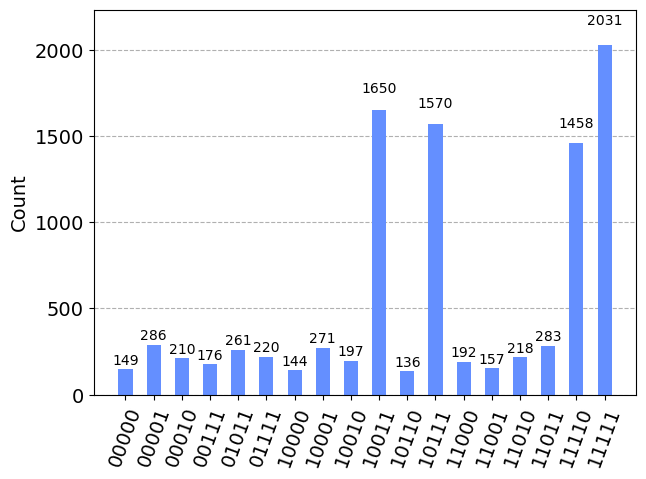

In [124]:

from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
# print("Final measurement counts:", sorted_dict)

plot_histogram(filtered_dict)

In [182]:
# 计算期望值
expectation = 0
for bitstring, count in sorted_dict.items():
    bitstring = invert_counts(bitstring)
    prob = count / 10000
    z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
    s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
    E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
    E2 = 0
    for j in range(len(bw)):
        for i in range(n):
            constant = 1
            for k in range(N):
                constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
            E2 += constant
    E2 = E2
    E3 = 0
    for j in range(m):
        constant1 = 0
        for i in range(n):
            constant2 = 1
            for k in range(N):
                constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
            constant1 += p[i, j] * constant2
        constant3 = 0
        for h in range(l):
            constant3 += 2 ** h * z_h[h]
        constant = max(0, constant1 - constant3)
        E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

    E = E1 + E2 + E3

    expectation += E * prob
print(expectation)

8.519600000000004


In [183]:
expectation = 0
bitstring = "10001011"
z_h = np.array([int(bit) for bit in bitstring[(n * N):]])
s_ik = np.array([int(bit) for bit in bitstring[:(n * N)]]).reshape(n, N)
E1 = np.sum([2 ** h * z for h, z in enumerate(z_h)])
E2 = 0
for j in range(len(bw)):
    for i in range(n):
        constant = 1
        for k in range(N):
            constant = constant * (1 - (s_ik[i, k] - bw[j, k]) ** 2)
        E2 += constant
E2 = K1 * E2
E3 = 0
for j in range(m):
    constant1 = 0
    # print("机器：", j)
    for i in range(n):
        constant2 = 1
        for k in range(N):
            constant2 = constant2 * (1 - (s_ik[i, k] - b[j, k]) ** 2)
        # print("constant2:", constant2)
        # print("p[i,j]:", p[i,j])
        constant1 += p[i, j] * constant2
    # print("constant1:", constant1)
    constant3 = 0
    for h in range(l):
        constant3 += 2 ** h * z_h[h]
    # print("constant3:", constant3)
    constant = max(0, constant1 - constant3)
    E3 += (constant) ** 2

    # alpha_s = np.max([0, np.sum(x_ij * p) - np.sum([2 ** h * z for h, z in enumerate(z_h)])])

E = E1 + K1 * E2 + P * E3
print(E1)
print(E2)
print(E3)
print(E)
# print(e1)
# print(e2)

3
0
1
33
